<a href="https://colab.research.google.com/github/AbedurRahman/Mosquito_images_classification/blob/main/Final_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import random
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = '/content/drive/MyDrive/Final Mosquito DataSet'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '../content/drive/MyDrive/Final Mosquito DataSet/TRAIN' 
seg_test_folders = '../content/drive/MyDrive/Final Mosquito DataSet/TEST'
seg_pred_folders = '../content/drive/MyDrive/Final Mosquito DataSet/PRED'

Number of images in the train set :  36
Number of images in the test set ;  36


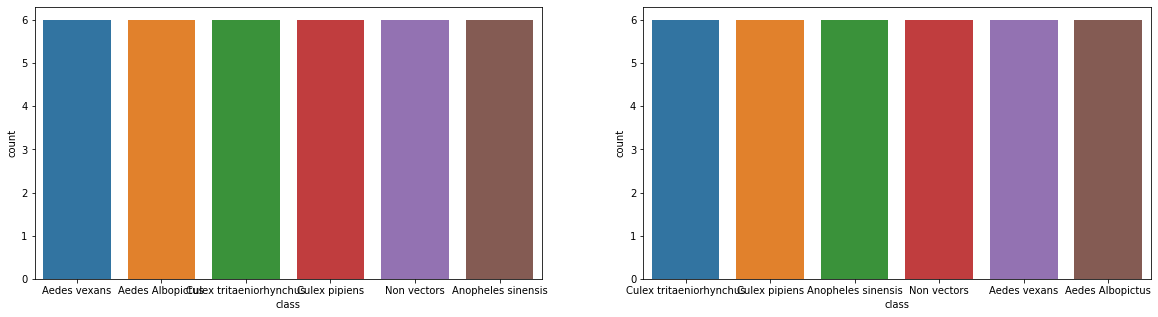

In [ ]:
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
plt.show()

In [ ]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                   shear_range=0.2,
                                   zoom_range=0.2)


train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224,224))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) 

validation_generator = validation_datagen.flow_from_directory(seg_test_folders, 
                                                              shuffle=True,
                                                              batch_size=1, 
                                                              class_mode='categorical', 
                                                              target_size=(224,224))

Found 2727 images belonging to 6 classes.
Found 739 images belonging to 6 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'Aedes Albopictus': 0, 'Aedes vexans': 1, 'Anopheles sinensis': 2, 'Culex pipiens': 3, 'Culex tritaeniorhynchus': 4, 'Non vectors': 5}
{0: 'Aedes Albopictus', 1: 'Aedes vexans', 2: 'Anopheles sinensis', 3: 'Culex pipiens', 4: 'Culex tritaeniorhynchus', 5: 'Non vectors'}


In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

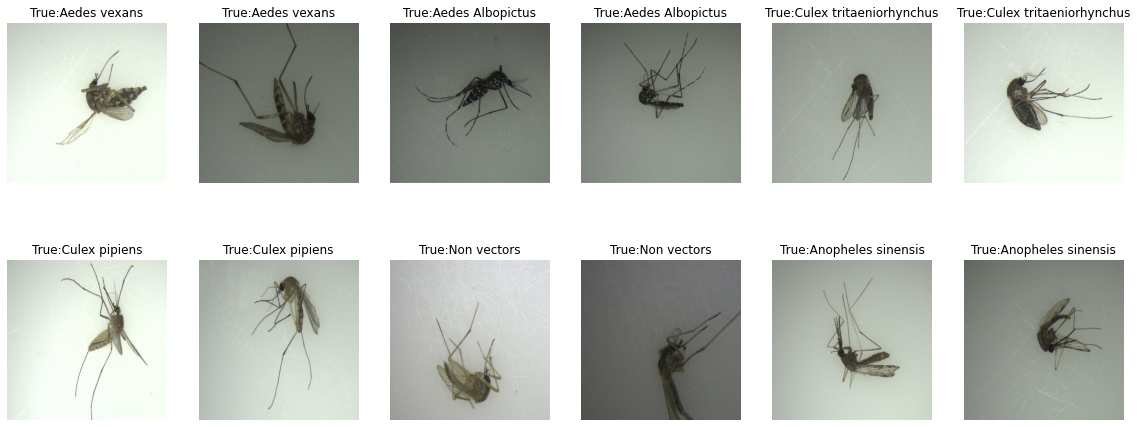

In [ ]:
show_few_images()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

# **My Model**

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
my_model = Sequential()
my_model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
my_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
my_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
my_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
my_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
my_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
my_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
my_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [ ]:
my_model.add(Flatten())
my_model.add(Dense(units=4096,activation="relu"))
my_model.add(Dense(units=4096,activation="relu"))
my_model.add(Dense(units=6, activation="softmax"))

In [ ]:
my_model.compile(loss = 'categorical_crossentropy', 
                          optimizer= 'adam',
                          metrics=['acc'])

In [ ]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 1.7951 - acc: 0.1562
Epoch 00001: val_acc improved from -inf to 0.15968, saving model to mymodel_16_-saved-model-01-acc-0.16.hdf5
43/43 [==============================] - 62s 1s/step - loss: 1.7951 - acc: 0.1562 - val_loss: 1.7918 - val_acc: 0.1597
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 1.7926 - acc: 0.1536
Epoch 00002: val_acc improved from 0.15968 to 0.16238, saving model to mymodel_16_-saved-model-02-acc-0.16.hdf5
43/43 [==============================] - 60s 1s/step - loss: 1.7926 - acc: 0.1536 - val_loss: 1.7918 - val_acc: 0.1624
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 1.7922 - acc: 0.1602
Epoch 00003: val_acc did not improve from 0.16238
43/43 [==============================] - 59s 1s/step - loss: 1.7922 - acc: 0.1602 - val_loss: 1.7918 - val_acc: 0.1624
Epoch 4/10
43/43 [==============================] - ETA: 0s - loss: 1.7919 - acc: 0.1573
Epoch 00004: val

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


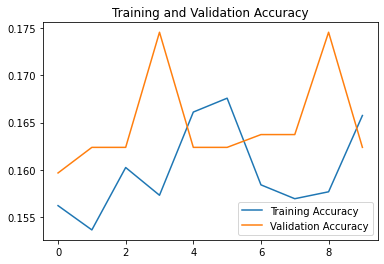

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


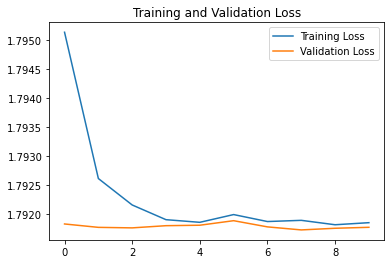

<Figure size 432x288 with 0 Axes>

In [ ]:
number_of_epochs = 10
mymodel_filepath = 'mymodel_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
mymodel_checkpoint = tf.keras.callbacks.ModelCheckpoint(mymodel_filepath, monitor='val_acc', 
                                                    verbose=1, 
                                                    save_best_only=True,
                                                    mode='max')
mymodel_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=5)

mymodel_history = my_model.fit(train_generator, 
                                      epochs = number_of_epochs ,
                                      validation_data = validation_generator,
                                      callbacks=[mymodel_checkpoint,mymodel_early_stopping],
                                      verbose=1)

do_history_stuff(mymodel_history, 'mymodel_model')

# **VGG16**

In [ ]:
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
vgg16_model = VGG16(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_tensor=Input(shape=(224,224,3)))

for layers in vgg16_model.layers:
            layers.trainable=False

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(256, activation = 'relu')(vgg_x)
vgg_x = Dense(6, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16_final_model.compile(loss = 'categorical_crossentropy', 
                          optimizer= 'adam',
                          metrics=['acc'])

In [ ]:
# VGG16
number_of_epochs = 50
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', 
                                                    verbose=1, 
                                                    save_best_only=True,
                                                    mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=5)

vgg16_history = vgg16_final_model.fit(train_generator, 
                                      epochs = number_of_epochs ,
                                      validation_data = validation_generator,
                                      callbacks=[vgg_checkpoint,vgg_early_stopping],
                                      verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.6949 - acc: 0.3154
Epoch 00001: val_acc improved from -inf to 0.46820, saving model to vgg_16_-saved-model-01-acc-0.47.hdf5
43/43 [==============================] - 52s 1s/step - loss: 1.6949 - acc: 0.3154 - val_loss: 1.5561 - val_acc: 0.4682
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 1.4720 - acc: 0.4837
Epoch 00002: val_acc improved from 0.46820 to 0.54263, saving model to vgg_16_-saved-model-02-acc-0.54.hdf5
43/43 [==============================] - 52s 1s/step - loss: 1.4720 - acc: 0.4837 - val_loss: 1.3597 - val_acc: 0.5426
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 1.3066 - acc: 0.5409
Epoch 00003: val_acc improved from 0.54263 to 0.60487, saving model to vgg_16_-saved-model-03-acc-0.60.hdf5
43/43 [==============================] - 52s 1s/step - loss: 1.3066 - acc: 0.5409 - val_loss: 1.2010 - val_acc: 0.6049
Epoch 4/50
43/43 [==============================] - ETA

# **InceptionV3**

In [ ]:
InceptionV3_model = InceptionV3(input_shape=(224,224,3),
                                weights='imagenet',
                                include_top=False)

for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(256, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)

In [ ]:

InceptionV3_x_final_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
InceptionV3_x_final_model.compile(optimizer='adam', 
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

Epoch 1/5
45/45 [==============================] - 80s 2s/step - loss: 0.1065 - accuracy: 0.9657 - val_loss: 1.1238 - val_accuracy: 0.8430
Epoch 2/5
45/45 [==============================] - 80s 2s/step - loss: 0.0972 - accuracy: 0.9664 - val_loss: 0.0936 - val_accuracy: 0.9770
Epoch 3/5
45/45 [==============================] - 77s 2s/step - loss: 0.0342 - accuracy: 0.9890 - val_loss: 0.1797 - val_accuracy: 0.9608
Epoch 4/5
45/45 [==============================] - 76s 2s/step - loss: 0.0659 - accuracy: 0.9798 - val_loss: 0.0940 - val_accuracy: 0.9689
Epoch 5/5
45/45 [==============================] - 76s 2s/step - loss: 0.0245 - accuracy: 0.9911 - val_loss: 0.0173 - val_accuracy: 0.9892


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


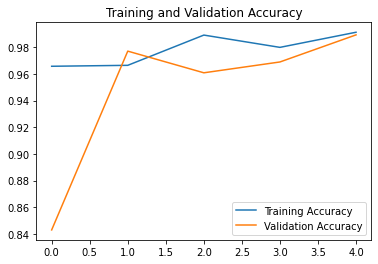

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


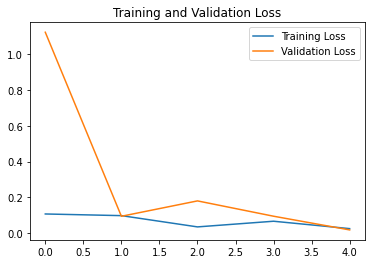

<Figure size 432x288 with 0 Axes>

In [ ]:
number_of_epochs =5
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'

inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, 
                                                          monitor='acc',
                                                          verbose=1, 
                                                          save_best_only=True,
                                                          mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, 
                                                    epochs = number_of_epochs,
                                                    validation_data = validation_generator,
                                                    callbacks=[inception_checkpoint,inception_early_stopping],
                                                    verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True) 

# **MobileNet**

In [ ]:
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
mobilenet_model = MobileNetV2(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_tensor=Input(shape=(224,224, 3)))

for layers in mobilenet_model.layers:
            layers.trainable=False

last_output = mobilenet_model.layers[-1].output
mobile_x = Flatten()(last_output)
mobile_x = Dense(256, activation = 'relu')(mobile_x)
mobile_x = Dense(6, activation = 'softmax')(mobile_x)
mobilenet_final_model = Model(mobilenet_model.input, mobile_x)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenet_final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
mobilenet_final_model.compile(loss = 'categorical_crossentropy', 
                          optimizer= 'adam',
                          metrics=['acc'])

Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 0.9550 - acc: 0.6462
Epoch 00001: val_acc improved from -inf to 0.81461, saving model to mobile_v2_-saved-model-01-acc-0.81.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


45/45 [==============================] - 71s 1s/step - loss: 0.9550 - acc: 0.6462 - val_loss: 0.5111 - val_acc: 0.8146
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 0.4738 - acc: 0.8290
Epoch 00002: val_acc did not improve from 0.81461
45/45 [==============================] - 66s 1s/step - loss: 0.4738 - acc: 0.8290 - val_loss: 0.5685 - val_acc: 0.7767
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 0.3706 - acc: 0.8651
Epoch 00003: val_acc improved from 0.81461 to 0.86874, saving model to mobile_v2_-saved-model-03-acc-0.87.hdf5
45/45 [==============================] - 65s 1s/step - loss: 0.3706 - acc: 0.8651 - val_loss: 0.3615 - val_acc: 0.8687
Epoch 4/15
45/45 [==============================] - ETA: 0s - loss: 0.2801 - acc: 0.9065
Epoch 00004: val_acc improved from 0.86874 to 0.88769, saving model to mobile_v2_-saved-model-04-acc-0.89.hdf5
45/45 [==============================] - 63s 1s/step - loss: 0.2801 - acc: 0.9065 - val_loss: 0.3113 - v

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


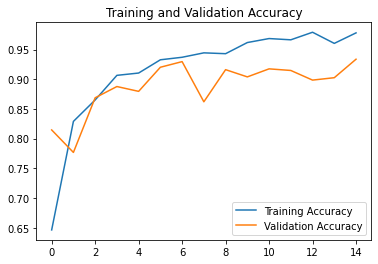

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


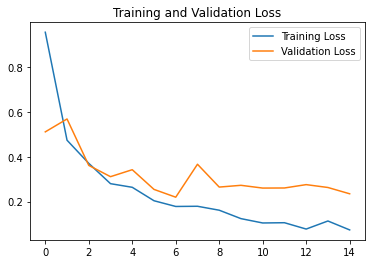

<Figure size 432x288 with 0 Axes>

In [ ]:
number_of_epochs = 10
mobile_filepath = 'mobile_v2_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
mobile_checkpoint = tf.keras.callbacks.ModelCheckpoint(mobile_filepath, monitor='val_acc', 
                                                    verbose=1, 
                                                    save_best_only=True,
                                                    mode='max')
mobile_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=5)

mobile_history = mobilenet_final_model.fit(train_generator, 
                                      epochs = number_of_epochs ,
                                      validation_data = validation_generator,
                                      callbacks=[mobile_checkpoint,mobile_early_stopping],
                                      verbose=1)

do_history_stuff(mobile_history, 'mobilenet_model')

# **Combining the best models of VGG16, Resnet50 & InceptionV3**

In [ ]:
vgg_best_model = vgg16_final_model
mymodel_best_model= model
inception_best_model = InceptionV3_x_final_model
mobile_best_model = mobilenet_final_model

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
mymodel_pred = []
vgg_pred = []
inception_pred = []
mobile_pred = []

for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255

        #vgg16
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #mymodel
        mymodel_image_prediction = np.argmax(mymodel_best_model.predict(np.array([img_normalized])))
        mymodel_pred.append(mymodel_image_prediction)
        

        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

    

        #mobile
        mobile_image_prediction = np.argmax(mobile_best_model.predict(np.array([img_normalized])))
        mobile_pred.append(mobile_image_prediction)
        
        
       
        
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([mymodel_image_prediction,vgg16_image_prediction, inception_image_prediction,mobile_image_prediction])                                  
        combined_model_pred.append(image_prediction)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

# **Performance**

**combined vote**

Model Accuracy 0.952638700947226
                         precision    recall  f1-score   support

       Aedes Albopictus       0.97      1.00      0.98       120
           Aedes vexans       0.95      0.89      0.92       118
     Anopheles sinensis       0.92      0.98      0.95       121
          Culex pipiens       0.97      0.88      0.92       129
Culex tritaeniorhynchus       0.95      1.00      0.98       120
            Non vectors       0.96      0.97      0.97       131

               accuracy                           0.95       739
              macro avg       0.95      0.95      0.95       739
           weighted avg       0.95      0.95      0.95       739



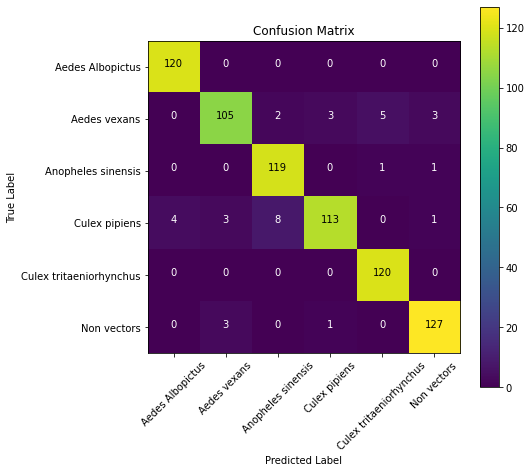

In [ ]:
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

**VGG16**

Model Accuracy 0.8457374830852503
                         precision    recall  f1-score   support

       Aedes Albopictus       0.95      0.99      0.97       120
           Aedes vexans       0.71      0.78      0.74       118
     Anopheles sinensis       0.88      0.78      0.82       121
          Culex pipiens       0.85      0.85      0.85       129
Culex tritaeniorhynchus       0.80      0.91      0.85       120
            Non vectors       0.89      0.77      0.83       131

               accuracy                           0.85       739
              macro avg       0.85      0.85      0.85       739
           weighted avg       0.85      0.85      0.85       739



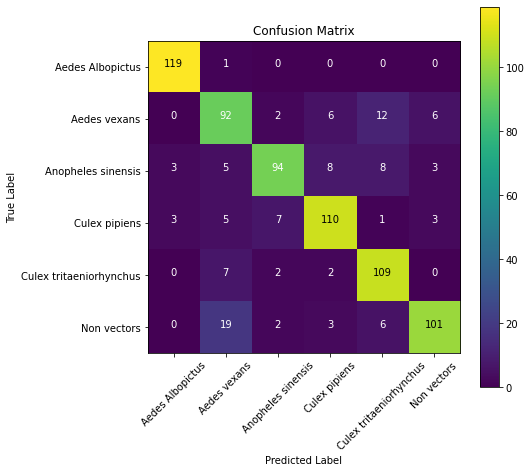

In [ ]:
# VGG model classification report
clf_report(true_value, vgg_pred)

**MobileNet**

Model Accuracy 0.912043301759134
                         precision    recall  f1-score   support

       Aedes Albopictus       0.92      0.99      0.95       120
           Aedes vexans       0.92      0.85      0.88       118
     Anopheles sinensis       0.80      0.98      0.88       121
          Culex pipiens       1.00      0.75      0.86       129
Culex tritaeniorhynchus       0.94      0.95      0.95       120
            Non vectors       0.93      0.95      0.94       131

               accuracy                           0.91       739
              macro avg       0.92      0.91      0.91       739
           weighted avg       0.92      0.91      0.91       739



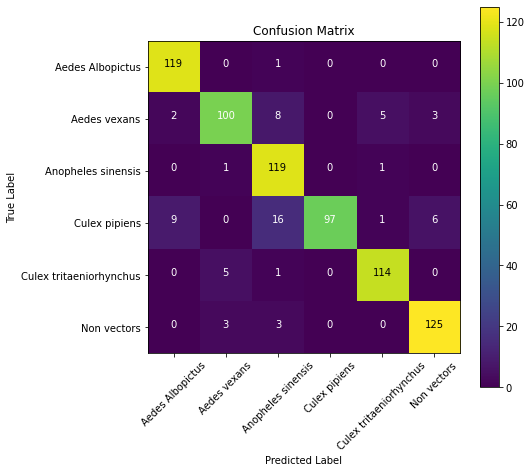

In [ ]:
#MobileNet model classification report
clf_report(true_value, mobile_pred)

**InceptionV3**

Model Accuracy 0.9418132611637348
                         precision    recall  f1-score   support

       Aedes Albopictus       0.92      0.99      0.95       120
           Aedes vexans       1.00      0.87      0.93       118
     Anopheles sinensis       0.84      0.98      0.90       121
          Culex pipiens       1.00      0.81      0.90       129
Culex tritaeniorhynchus       0.93      1.00      0.96       120
            Non vectors       1.00      0.99      1.00       131

               accuracy                           0.94       739
              macro avg       0.95      0.94      0.94       739
           weighted avg       0.95      0.94      0.94       739



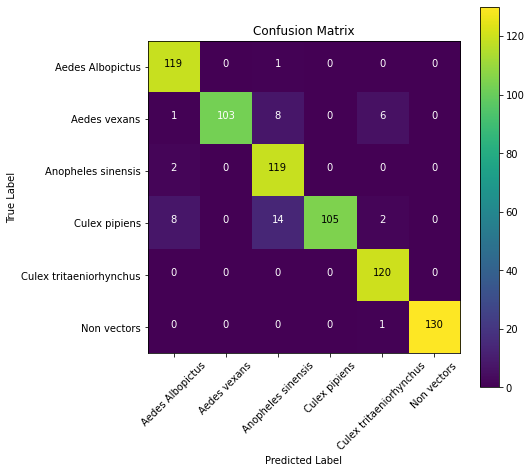

In [ ]:
# Inception model classification report
clf_report(true_value, inception_pred)